# SAM Analysis
Designed to calculate and plot the SAM. Link to [Data analysis](#Data-Analysis).

#### Dask

<br>

#### Choices for data

In [1]:
#Experiment data for analysis
dataVariableId = 'psl'
dataSourceId = "UKESM1-0-LL"
experimentId = "historical"
tableId = "Amon"
memberId = "r1i1p1f2"

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
maskName = "OceanMaskVolcello2"

<br>

#### Imports

In [2]:
#import cartopy.crs as ccrs
#import cdstoolbox as ct
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Data loading
<b>Loading the ESM data</b>

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.source_id.eq(dataSourceId) & df.table_id.eq(tableId) & df.experiment_id.eq(experimentId)& df.member_id.eq(memberId)]
#dfFilt = dfFilt[df.member_id.eq(memberId)] #selected member ID

zstore = dfFilt.zstore.values[0]
mapper = fsspec.get_mapper(zstore)
fileRaw = xr.open_zarr(mapper, consolidated=True)

#Formatting dates into np.datetime64 format
startDateIterate = np.datetime64(fileRaw['time'].values[0],'M')
endDateIterate = np.datetime64(fileRaw['time'].values[-1],'M') + np.timedelta64(1,'M')
fileRaw['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
fileRaw['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 

dfESMLat = fileRaw.psl.sel(lat=latSel) #Selection of latitude
dfESMLat = dfESMLat.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLat["time"][0].values
globalDateInc = dfESMLat["time"][1].values - globalStartDate
globalEndDateIn = dfESMLat["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM data sucessfully loaded.")

ESM data sucessfully loaded.


<br>
<b>Loading the ocean mask</b>

In [4]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded into oceanMask")

Mask Loaded into oceanMask


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
<li>SAMCalculateRaw - returns a data array of the difference in pressures between lat -40 and lat -65 (tolerance ±2°) not normalised.
</ul>

In [42]:
def SAMCalculateRaw(dataArray):
    P40 = dataArray.sel(lat=slice(-42, -38))
    P40 = P40.mean(dim=["lat", "lon"])
    P40 = P40.reset_coords(drop=True)
    P65 = dataArray.sel(lat=slice(-67, -63))
    P65 = P65.mean(dim=["lat", "lon"])
    P65 = P65.reset_coords(drop=True)
    SAMIndex = P40 - P65
    return SAMIndex

def SAMCalculateNorm(dataArray, normalisedDataArray):
    normalisedDataNP = normalisedDataArray.values
    SAMIndexRaw = SAMCalculateRaw(dataArray)
    
    dates = pd.DatetimeIndex(SAMIndexRaw["time"].values)
    dateLen = len(dates.year.unique().values)
    startMon = dates[0].month - 1
    endMon = -13 + dates[-1].month
    
    normalisedDataNPList = np.empty(shape=(0,12))
    for i in range(dateLen):
        normalisedDataNPList = np.append(normalisedDataNPList, normalisedDataNP)

    normalisedDataNPList = np.append(normalisedDataNPList, 0) #Adding empty element to allow for refencing end point
    SAMIndexNorm = SAMIndexRaw - normalisedDataNPList[startMon:endMon]
    
    return SAMIndexNorm

print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li>mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number.
</ul>

In [6]:
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map.'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))

    
def timePlot(dataSet, title, plotNo):
    '''Displays SAM index over time for any given range.'''
    plt.figure(plotNo, figsize = (20,10))
    dataSet.plot(label = dataSet.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel("SAM Index")
    plt.title(str(title))
    
    
def timePlotStd(dataSetMean, dataSetError, title, plotNo):
    '''Displays SAM index with standard deviations over a 12 month period.'''
    plt.figure(plotNo, figsize = (10,10))
    plt.errorbar(months, dataSetMean.values, yerr=dataSetError.values, label = dataSetMean.name, capsize=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Month")
    plt.ylabel("SAM Index")
    plt.title(str(title))
    
    
def timePlotYear(dataArray, title, plotNo):
    '''Displays SAM index for a 12 month period starting in January. Compatible with timePlotStd.'''
    plt.figure(plotNo)
    plt.plot(months, dataArray.values, label = dataArray.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Month")
    plt.ylabel("SAM Index")
    plt.title(str(title))

print("Plotting functions defined")

Plotting functions defined


<br>

#### Plotting the mask

In [7]:
#mapPlot(oceanMask, "Loaded Southern Ocean Mask", 1)

<br>

#### Data Analysis

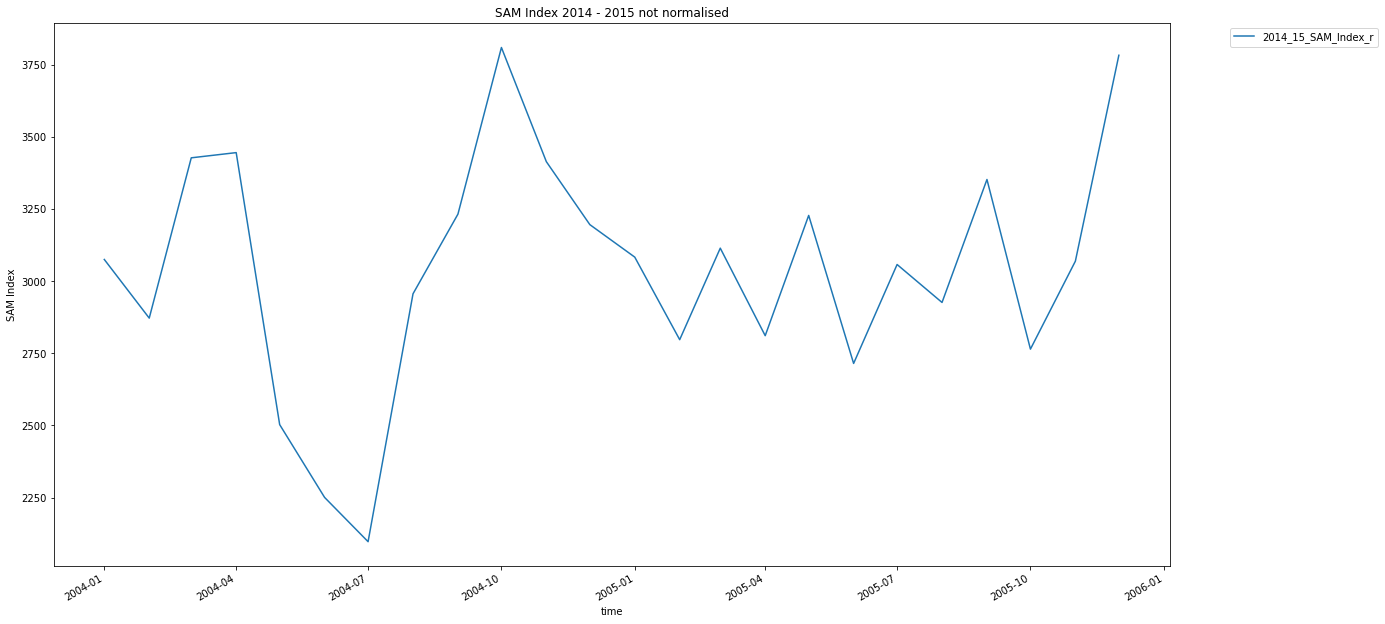

In [8]:
SAM2014_15 = SAMCalculateRaw(dfESMLat.sel(time=slice('2004-01','2005-12')))
SAM2014_15.name = "2014_15_SAM_Index_r" #_r indicates raw, meaning not normalised
timePlot(SAM2014_15, "SAM Index 2014 - 2015 not normalised", 1)
plt.show()

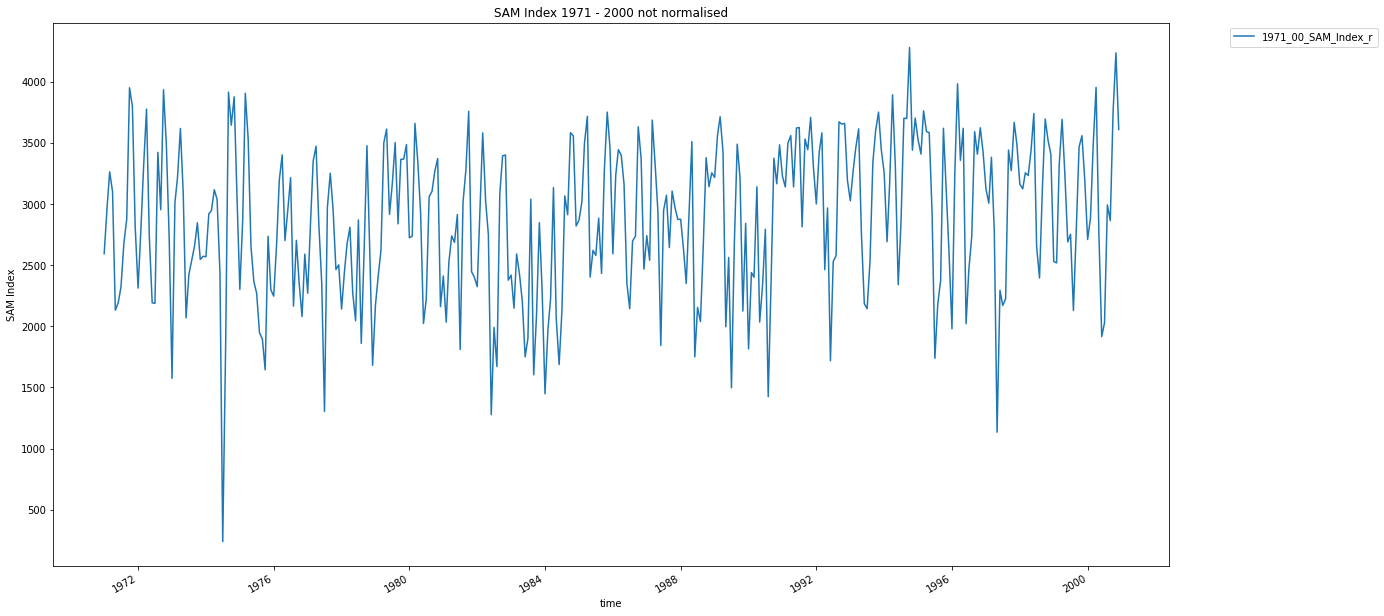

In [38]:
SAM1971_00 = SAMCalculateRaw(dfESMLat.sel(time=slice('1971-01','2000-12')))
SAM1971_00.name = "1971_00_SAM_Index_r" #_r indicates raw, meaning not normalised
timePlot(SAM1971_00, "SAM Index 1971 - 2000 not normalised", 1)
plt.show()

In [35]:
#SAM calculation for 1971 - 2000
SAMNormaliseMonthly = SAM1971_00.groupby("time.month")
SAMNormaliseMonthlyMeans = SAMNormaliseMonthly.mean("time", keep_attrs=True)
SAMNormaliseMonthlyStds = SAMNormaliseMonthly.std("time", keep_attrs=True)
SAMNormaliseMonthlyMeans.name = "1971_2000_SAM_Index_mean" #_r indicates raw, meaning not normalised

#SAM calculation for 1971 and 2000
SAM1971 = SAMCalculateRaw(dfESMLat.sel(time=slice("1971-01","1971-12")))
SAM1971.name = "1971_SAM_Index_r"
SAM2000 = SAMCalculateRaw(dfESMLat.sel(time=slice("2000-01","2000-12")))
SAM2000.name = "2000_SAM_Index_r"

print("SAM index for 1971-2000 calculated, with years 1971 and 2000 additionally calculated on a single year basis.")

SAM index for 1971-2000 calculated, with years 1971 and 2000 additionally calculated on a single year basis.


In [27]:
SAM1971N = SAMCalculateNorm(dfESMLat.sel(time=slice("1971-01","1971-12")), SAMNormaliseMonthlyMeans)
SAM1971N.name = "1971_SAM_Index_n"
SAM2000N = SAMCalculateNorm(dfESMLat.sel(time=slice("2000-01","2000-12")), SAMNormaliseMonthlyMeans)
SAM2000N.name = "2000_SAM_Index_n"
print("SAM index normalised calculated for 1971 and 2000")

0 -1
0 -1
SAM index normalised calculated for 1971 and 2000


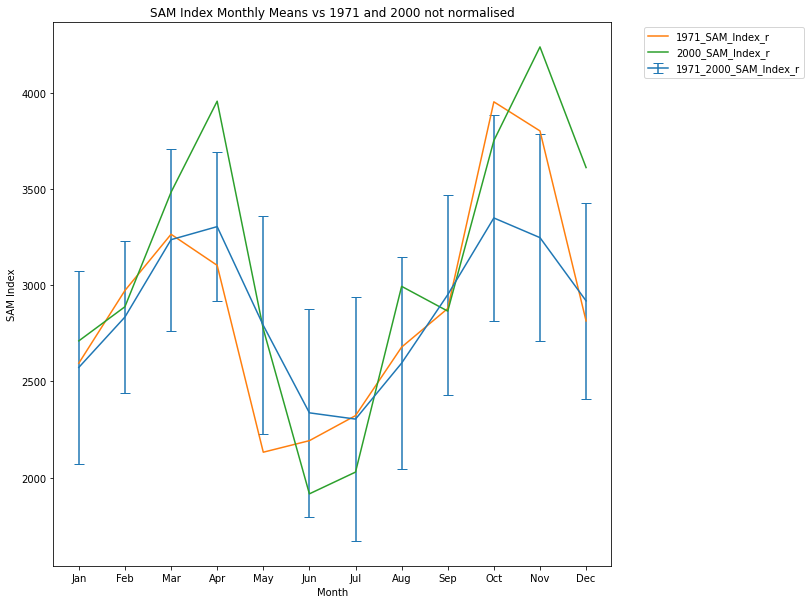

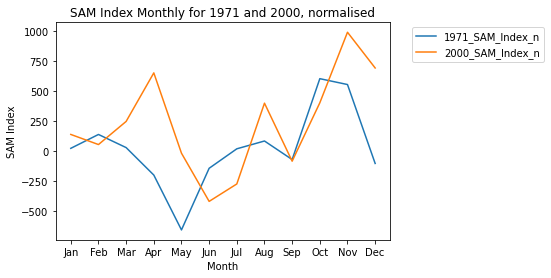

In [12]:
timePlotStd(SAMNormaliseMonthlyMeans, SAMNormaliseMonthlyStds, "SAM Index Monthly Means 1971 - 2000 not normalised", 1)
timePlotYear(SAM1971, "SAM Index Monthly Means vs 1971 not normalised", 1)
timePlotYear(SAM2000, "SAM Index Monthly Means vs 1971 and 2000 not normalised", 1)
timePlotYear(SAM1971N, "SAM Index Monthly for 1971, normalised", 2)
timePlotYear(SAM2000N, "SAM Index Monthly for 1971 and 2000, normalised", 2)
plt.show()

In [52]:
testData = dfESMLat.sel(time=slice('1971-01','1973-12'))
testSAM = SAMCalculateRaw(testData)
testSAM.name = "1971_73_SAM_Index_r"
testSAMN = SAMCalculateNorm(testData, SAMNormaliseMonthlyMeans)
testSAMN.name = "1971_73_SAM_Index_n"

dates = pd.DatetimeIndex(testSAM["time"].values)
dateLen = len(dates.year.unique().values)
normalisedDataNPList = np.empty(shape=(0,12))
for i in range(dateLen):
    normalisedDataNPList = np.append(normalisedDataNPList, normalisedDataNP)
    
testDiff = testSAM - normalisedDataNPList
testDiff.name = "1971_73_SAM_Index_n_manual"
    
print("SAM index for selected time period calculated.")

SAM index for selected time period calculated.


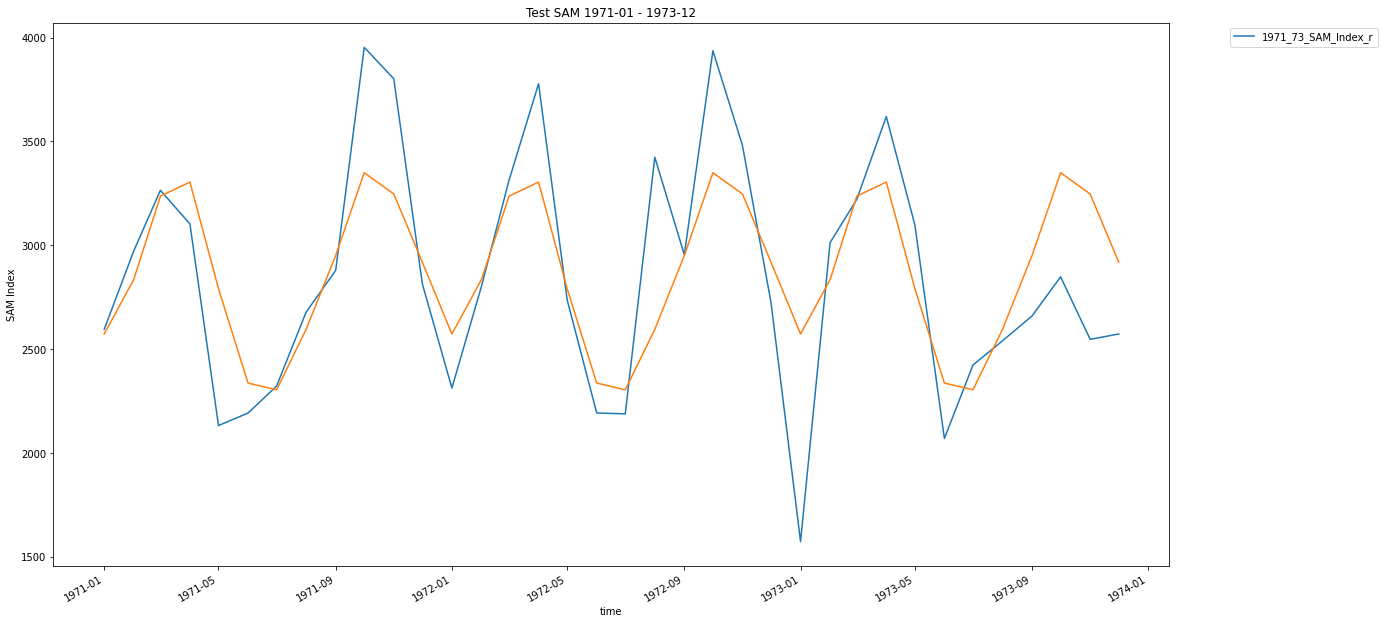

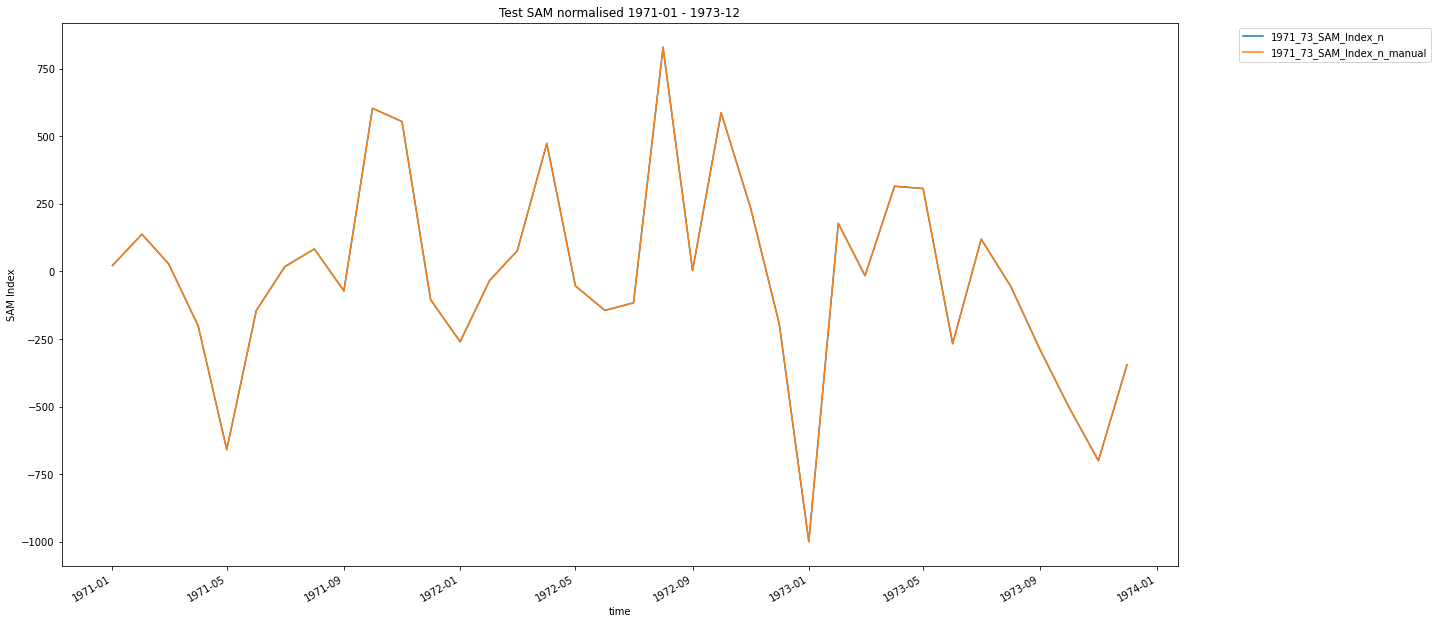

In [53]:
timePlot(testSAM, "Test SAM 1971-01 - 1973-12", 1)
ax = plt.plot(testSAM["time"],normalisedDataNPList, label = "1971_00_SAM_Index_mean")
timePlot(testSAMN, "Test SAM normalised 1971-01 - 1973-12", 2)
timePlot(testDiff, "Test SAM normalised 1971-01 - 1973-12", 2)